In [1]:
import shap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split

c:\Users\User\Desktop\test_pefindo\ds\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
sns.set_style("whitegrid")

# Load data and drop feature leakage
df = pd.read_csv("../data/credit_scoring.csv")
df.drop(columns=["leak_col_good", "leak_col_subtle"], inplace=True)
df.head()

,application_id,age,monthly_income,loan_amount,previous_defaults,credit_score,default
0,501000,41,13995609,5982664,0,624,0
1,501001,58,13683833,3711198,0,809,0
2,501002,33,9417391,7172332,0,647,0
3,501003,45,6861811,8661056,0,450,0
4,501004,22,5640742,4520669,1,816,0


# Check Dataset

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   application_id     6000 non-null   int64
 1   age                6000 non-null   int64
 2   monthly_income     6000 non-null   int64
 3   loan_amount        6000 non-null   int64
 4   previous_defaults  6000 non-null   int64
 5   credit_score       6000 non-null   int64
 6   default            6000 non-null   int64
dtypes: int64(7)
memory usage: 328.3 KB


In [4]:
df.describe()

,application_id,age,monthly_income,loan_amount,previous_defaults,credit_score,default
count,6000.000000,6000.000000,6.000000e+03,6.000000e+03,6000.000000,6000.000000,6000.000000
mean,503999.500000,40.321500,1.140386e+07,8.001122e+06,0.243667,575.979833,0.012167
std,1732.195139,11.300697,4.912598e+06,4.071786e+06,0.484767,158.328931,0.109639
min,501000.000000,21.000000,3.000310e+06,1.000794e+06,0.000000,300.000000,0.000000
25%,502499.750000,31.000000,7.163379e+06,4.440939e+06,0.000000,438.750000,0.000000
50%,503999.500000,41.000000,1.129945e+07,7.982304e+06,0.000000,577.500000,0.000000
75%,505499.250000,50.000000,1.573705e+07,1.153144e+07,0.000000,713.000000,0.000000
max,506999.000000,59.000000,1.998622e+07,1.499858e+07,3.000000,849.000000,1.000000


In [5]:
df.isnull().sum()

application_id       0
age                  0
monthly_income       0
loan_amount          0
previous_defaults    0
credit_score         0
default              0
dtype: int64

Dari sini kita bisa melihat bahwa tidak ada null pada daset

# Basic and simple EDA

###  Check distribusi fitur target

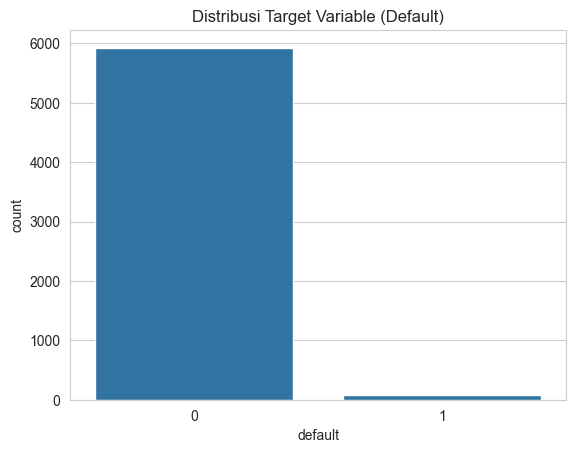

In [6]:
df.default.value_counts(normalize=True)
sns.countplot(x="default", data=df)
plt.title("Distribusi Target Variable (Default)")
plt.show()

 Perbandingan yang sangat jauh, ekstrim imbalance (1:81) untuk kasus gagal bayar dan tidak. Dari sini kita bisa mengetahui bahwa terdapat imbalance dataset pada kolom target, untuk mengatasi hal ini bisa menggunakan oversampling atau bahkan SMOTE untuk menghidari overfit karena duplikat data dari oversampling. Karena demikian metrik akurasi tidak akan cukup untuk evaluasi model. Metrik seperti precision, recall dant terutama F1-score, dan AUC-ROC akan lebih relevan untuk evaluasi model pada kasus ini

### Analisis Setiap Fitur

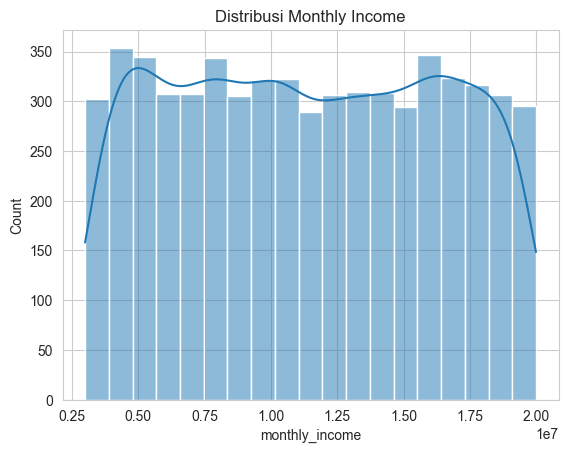

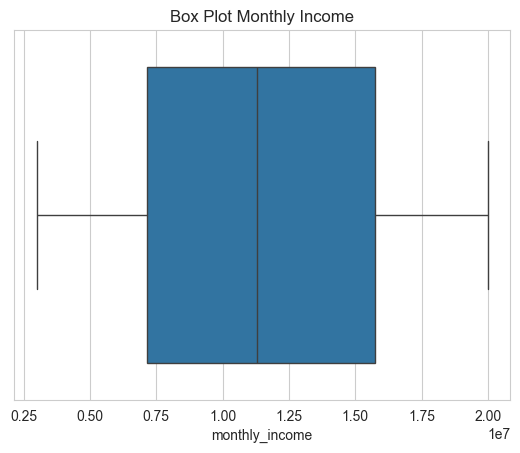

In [7]:
# Fitur monthly income
sns.histplot(df.monthly_income, kde=True)
plt.title("Distribusi Monthly Income")
plt.show()

sns.boxplot(x=df.monthly_income)
plt.title("Box Plot Monthly Income")
plt.show()

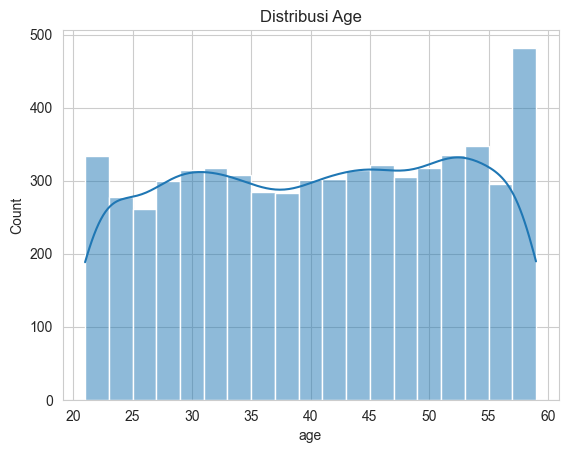

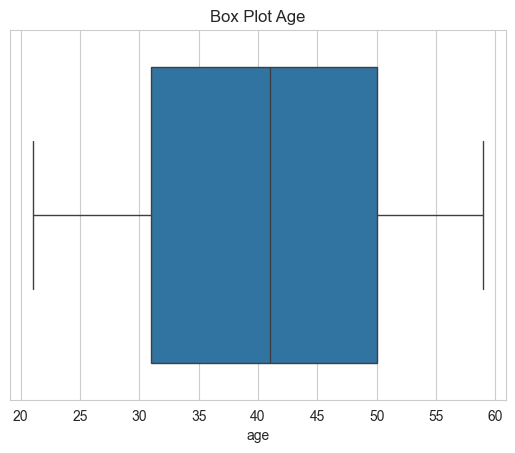

In [8]:
# Fitur age
sns.histplot(df.age, kde=True)
plt.title("Distribusi Age")
plt.show()

sns.boxplot(x=df.age)
plt.title("Box Plot Age")
plt.show()

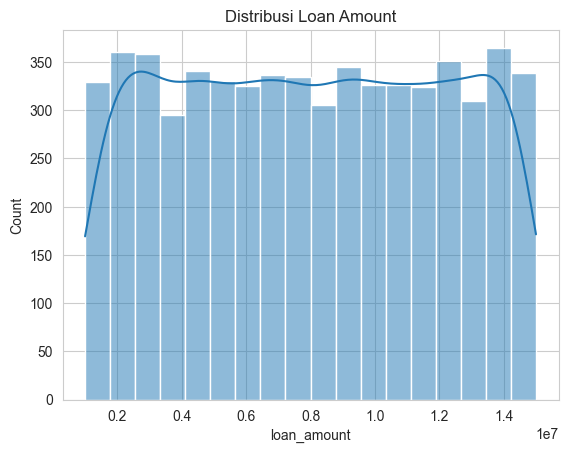

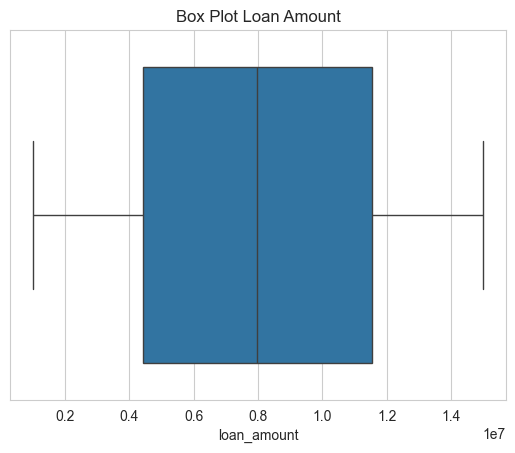

In [9]:
# Fitur loan amount
sns.histplot(df.loan_amount, kde=True)
plt.title("Distribusi Loan Amount")
plt.show()

sns.boxplot(x=df.loan_amount)
plt.title("Box Plot Loan Amount")
plt.show()

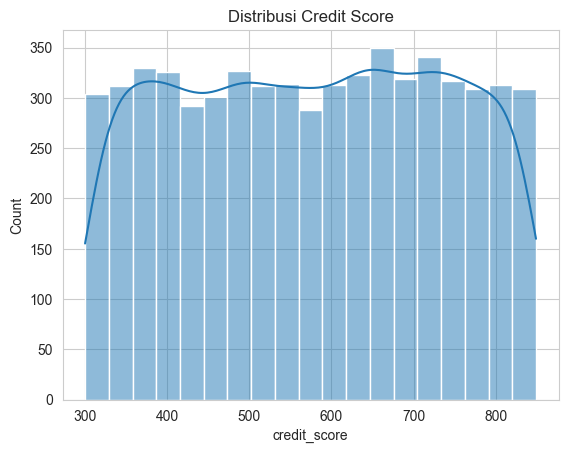

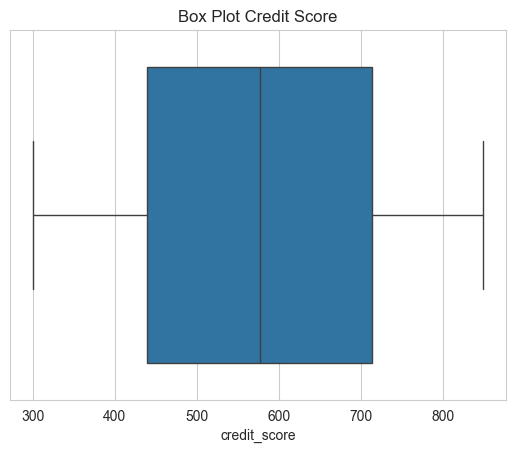

In [10]:
# Fitur credit score
sns.histplot(df.credit_score, kde=True)
plt.title("Distribusi Credit Score")
plt.show()

sns.boxplot(x=df.credit_score)
plt.title("Box Plot Credit Score")
plt.show()

Berdasarkan EDA di atas, distribusi untuk setiap fitur terlihat cukup merata di seluruh rentang nilainya. Tidak ada fitur yang terlihat memiliki distribusi yang sangat miring atau bahkan outlier yang mencolok. Hal ini menunjukkan bahwa data menyerupai distribusi uniform, di mana nilai nilai relatif seimbang

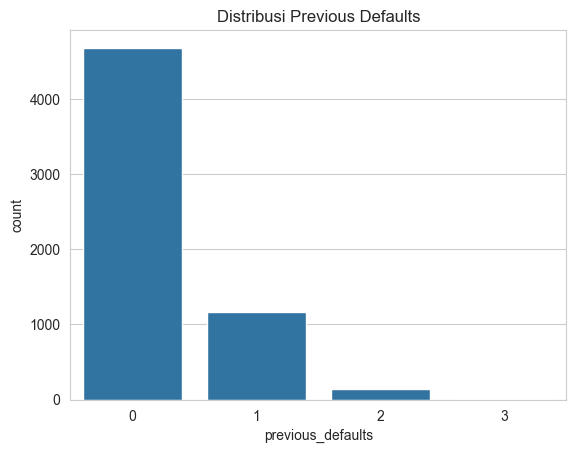

In [11]:
# Fitur previous default
sns.countplot(x="previous_defaults", data=df)
plt.title("Distribusi Previous Defaults")
plt.show()

EDA di atas menunjukkan bahwa ada sedikit pelanggan yang melakukan gagal bayar selama 2 kali dan sedikit sekali yang melakukan gagal bayar selama 3 kali. 

### Analisis Hubungan Fitur dengan Target

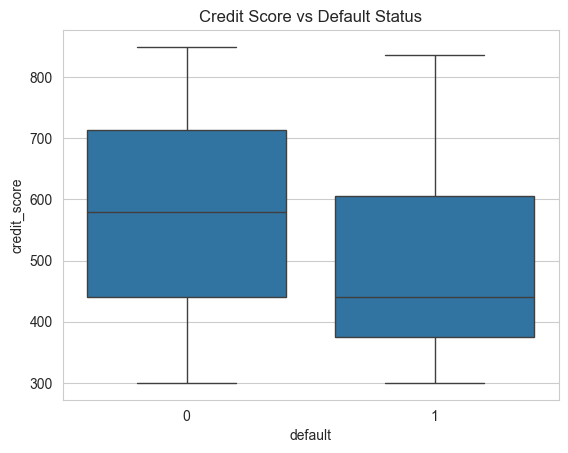

In [12]:
# Fitur credit score
sns.boxplot(x="default", y="credit_score", data=df)
plt.title("Credit Score vs Default Status")
plt.show()

Terlihat dari visualisasi di atas menunjukkan semakin rendah credit score semakin besar juga kemungkinan customer akan melakukan gagal bayar, sebaliknya semakin tinggi credit score semakin tinggi juga custoemr tidak akan melakukan gagal bayar. Di sini bisa dilihat dari nilai median dari dua kategori yang berbeda, dimana kelompok credit score besar memiliki median sekitar 580 sedangkan lainnya memiliki median sekitar 430

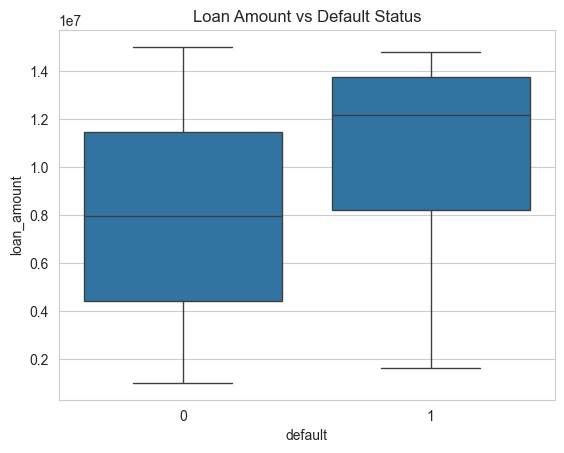

In [13]:
# Fitur credit score
sns.boxplot(x="default", y="loan_amount", data=df)
plt.title("Loan Amount vs Default Status")
plt.show()

Bisa kita lihat bahwa fitur loan amount juga berpengaruh terhadap target, dimana semakin besar loan amountnya semakin besar juga kemungkinan customer akan melakukan gagal bayar, sebaliknya semakin kecil loan amount semakin kecil juga customer tidak akan melakukan gagal bayar

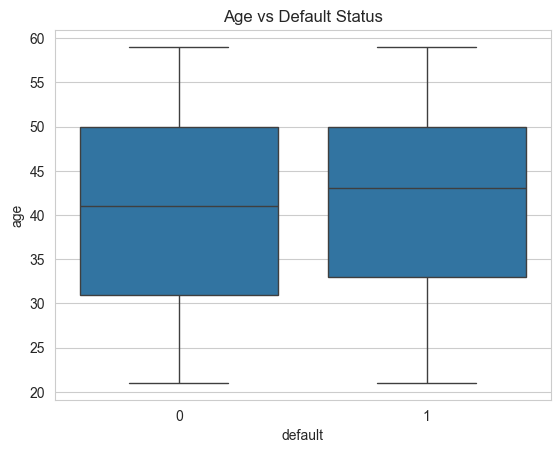

In [14]:
# Fitur credit score
sns.boxplot(x="default", y="age", data=df)
plt.title("Age vs Default Status")
plt.show()

Fitur age tidak memiliki perbedaan yang signifikan, bisa terlihat bahwa tidak ada hubungan usia untuk menentukan apakah customer tersebut akan melakukan gagal bayar atau tidak. Dalam pemodelan, fitur ini kemungkinan besar akan dianggap sebagai prediktor yang kurang relevan

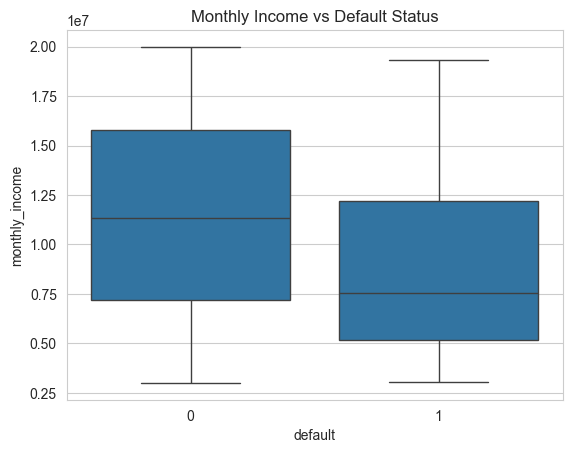

In [15]:
# Fitur credit score
sns.boxplot(x="default", y="monthly_income", data=df)
plt.title("Monthly Income vs Default Status")
plt.show()

Terlihat bahwa fitur monthly income memiliki hubungan dengan target, dimana semakin tinggi monthly income semakin kecil juga kemungkinan customer akan melakukan gagal bayar, sebaliknya semakin rendah monthly income semakin besar pula kemungkinan customer akan melakukan gagal bayar. Bisa kita lihat dari median dari dua kategori yang berbeda, dimana kelompok monthly income besar memiliki median yang lebih besar dibandingkan kelompok lainnya.

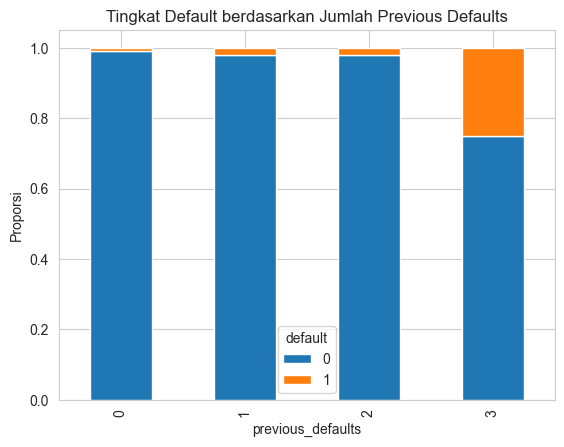

In [16]:
# Fitur previous defaults
pd.crosstab(df.previous_defaults, df.default, normalize="index").plot(kind="bar", stacked=True)
plt.title("Tingkat Default berdasarkan Jumlah Previous Defaults")
plt.ylabel("Proporsi")
plt.show()

# Modeling and Feature Engineering

In [17]:
# Create dti_ratio feature (presentase pendapatan bulanan yang digunakan untuk membayar pinjaman)
df["dfi_ratio"] = df.loan_amount / (df.monthly_income + 1e-6) # Mencegah pembagian dengan 0

# loan_to_score_ratio (Rasio pinjaman terhadap Skor kredit)
df["loan_to_score_ratio"] = df.loan_amount / (df.credit_score + 1e-6)

# age_x_credit_score (credit score tinggi di usia muda mungkin mengindikasi bahwa kemungkinan kecil customer akan melakukan galbay)
df["age_x_credit_score"] = df.age * df.credit_score

# age_group
bins = [18, 30, 45, 60, 80]
labels = ["Muda (18-30)", "Dewasa (31-45)", "Paruh Baya (46-60)", "Senior (60+)"]
df["age_group"] = pd.cut(df.age, bins=bins, labels=labels, right=False)

# low_income
low_income_threshold = df['monthly_income'].quantile(0.25)
df['is_low_income'] = (df['monthly_income'] < low_income_threshold).astype(int)


In [18]:
df.head()

,application_id,age,monthly_income,loan_amount,previous_defaults,credit_score,default,dfi_ratio,loan_to_score_ratio,age_x_credit_score,age_group,is_low_income
0,501000,41,13995609,5982664,0,624,0,0.427467,9587.602549,25584,Dewasa (31-45),0
1,501001,58,13683833,3711198,0,809,0,0.271210,4587.389364,46922,Paruh Baya (46-60),0
2,501002,33,9417391,7172332,0,647,0,0.761605,11085.520848,21351,Dewasa (31-45),0
3,501003,45,6861811,8661056,0,450,0,1.262211,19246.791068,20250,Paruh Baya (46-60),1
4,501004,22,5640742,4520669,1,816,0,0.801432,5540.035532,17952,Muda (18-30),1


In [19]:
# Encode dataset
df_encoded = pd.get_dummies(df, columns=['age_group'])
df_encoded.head()

,application_id,age,monthly_income,loan_amount,previous_defaults,credit_score,default,dfi_ratio,loan_to_score_ratio,age_x_credit_score,is_low_income,age_group_Muda (18-30),age_group_Dewasa (31-45),age_group_Paruh Baya (46-60),age_group_Senior (60+)
0,501000,41,13995609,5982664,0,624,0,0.427467,9587.602549,25584,0,False,True,False,False
1,501001,58,13683833,3711198,0,809,0,0.271210,4587.389364,46922,0,False,False,True,False
2,501002,33,9417391,7172332,0,647,0,0.761605,11085.520848,21351,0,False,True,False,False
3,501003,45,6861811,8661056,0,450,0,1.262211,19246.791068,20250,1,False,False,True,False
4,501004,22,5640742,4520669,1,816,0,0.801432,5540.035532,17952,1,True,False,False,False


In [20]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df_encoded["age_group_Muda (18-30)"] = le.fit_transform(df_encoded["age_group_Muda (18-30)"])
df_encoded["age_group_Dewasa (31-45)"] = le.fit_transform(df_encoded["age_group_Dewasa (31-45)"])
df_encoded["age_group_Paruh Baya (46-60)"] = le.fit_transform(df_encoded["age_group_Muda (18-30)"])
df_encoded["age_group_Senior (60+)"] = le.fit_transform(df_encoded["age_group_Senior (60+)"])

df_encoded.head()

,application_id,age,monthly_income,loan_amount,previous_defaults,credit_score,default,dfi_ratio,loan_to_score_ratio,age_x_credit_score,is_low_income,age_group_Muda (18-30),age_group_Dewasa (31-45),age_group_Paruh Baya (46-60),age_group_Senior (60+)
0,501000,41,13995609,5982664,0,624,0,0.427467,9587.602549,25584,0,0,1,0,0
1,501001,58,13683833,3711198,0,809,0,0.271210,4587.389364,46922,0,0,0,0,0
2,501002,33,9417391,7172332,0,647,0,0.761605,11085.520848,21351,0,0,1,0,0
3,501003,45,6861811,8661056,0,450,0,1.262211,19246.791068,20250,1,0,0,0,0
4,501004,22,5640742,4520669,1,816,0,0.801432,5540.035532,17952,1,1,0,1,0


In [21]:
X = df_encoded.drop(columns=["default", "application_id"])
y = df_encoded["default"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print(f"Total data training: {X_train.shape}")
print(f"Total data test: {X_test.shape}")

Total data training: (4800, 13)
Total data test: (1200, 13)


In [22]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)


In [23]:
import os
os.environ["SCIPY_ARRAY_API"] = "1"

from sklearn.model_selection import StratifiedKFold, cross_val_score
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as pl

print("------Eksperimen 1: Model with Class Weighting------")
lr = LogisticRegression(solver="liblinear", class_weight="balanced", random_state=42)
cross_val = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

model_score = cross_val_score(lr, X_train_scaled, y_train, cv=cross_val, scoring="roc_auc")
print(f"Model score cross validation: {model_score}")
print(f"Rata-rata ROC AUC (dengan Class Weighting): {model_score.mean():.4f}\n")

print("------Eksperimen 2: Model with SMOTE------")
pipeline_smote = pl(steps=[
    ("smote", SMOTE(random_state=42)),
    ("classifier", LogisticRegression(solver="liblinear", random_state=42))
])

scores_smote = cross_val_score(pipeline_smote, X_train_scaled, y_train, cv=cross_val, scoring="roc_auc")
print(scores_smote)
print(f"Rata-rata ROC AUC (dengan SMOTE): {scores_smote.mean():.4f}\n")


------Eksperimen 1: Model with Class Weighting------
Model score cross validation: [0.7455695  0.79605326 0.79940225 0.86049578 0.80133615]
Rata-rata ROC AUC (dengan Class Weighting): 0.8006

------Eksperimen 2: Model with SMOTE------
[0.74135454 0.79260466 0.81170886 0.85144163 0.78683193]
Rata-rata ROC AUC (dengan SMOTE): 0.7968



Terlihat dari auc_score dengan menggunakan dan tidak menggunakan SMOTE hasilnya tidak jauh berbeda, karena itu saya memutuskan untuk menggunakan model logistic tanpa menggunakan SMOTE dan dengan Class Weighting

In [24]:
from sklearn.metrics import classification_report, roc_auc_score

lr_final_model = LogisticRegression(solver="liblinear", class_weight="balanced", random_state=42)
lr_final_model.fit(X_train_scaled, y_train)

y_pred = lr_final_model.predict(X_test_scaled)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.73      0.84      1185
           1       0.03      0.67      0.06        15

    accuracy                           0.73      1200
   macro avg       0.51      0.70      0.45      1200
weighted avg       0.98      0.73      0.83      1200



In [25]:
# Check ROC-AUC score
lr_final_model_proba = LogisticRegression(solver="liblinear", class_weight="balanced", random_state=42)
lr_final_model_proba.fit(X_train_scaled, y_train)

y_pred_proba = lr_final_model_proba.predict_proba(X_test_scaled)[:,1]
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"ROC AUC Score: {roc_auc}")

ROC AUC Score: 0.7121237693389593


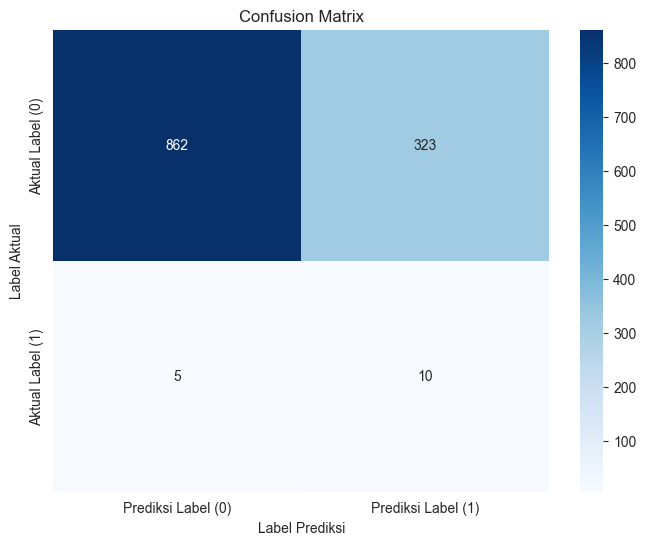

In [26]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Prediksi Label (0)", "Prediksi Label (1)"],
            yticklabels=["Aktual Label (0)", "Aktual Label (1)"])
plt.ylabel("Label Aktual")
plt.xlabel("Label Prediksi")
plt.title("Confusion Matrix")
plt.show()

Dari hasil classification report dan confusion matrix di atas, bisa diambil kesimpulan bahwa model mampu mengklasifikasi data minority (galbay) dengan cukup baik (10 dari 15 data). Namun kekurangannya adalah biaya operasional yang sangat tinggi, karena miss klasifikasi customer baik yang lumayan banyak

c:\Users\User\Desktop\test_pefindo\ds\Lib\site-packages\xgboost\training.py:183: UserWarning: [20:26:48] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "n_estimator", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\User\Desktop\test_pefindo\ds\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\User\Desktop\test_pefindo\ds\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\User\Desktop\test_pefindo\ds\Lib\site-pa

------Hasil Model Klasifikasi XGBoost------
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1185
           1       0.00      0.00      0.00        15

    accuracy                           0.99      1200
   macro avg       0.49      0.50      0.50      1200
weighted avg       0.98      0.99      0.98      1200

------Confusion Matrix XGBoost------


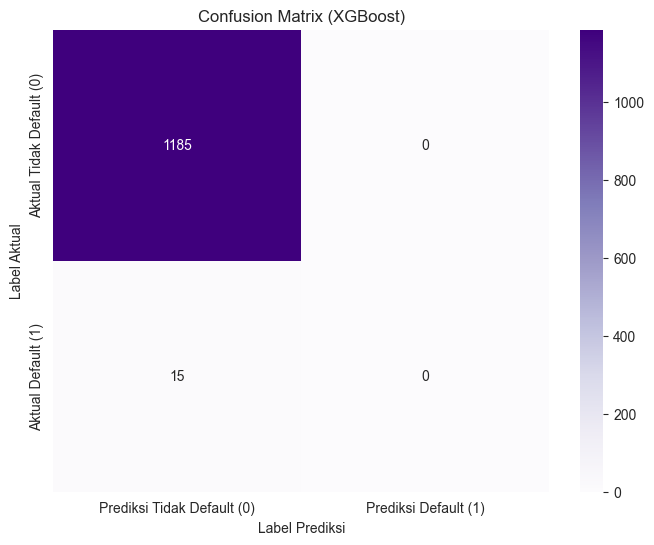

In [27]:
# Menggunakan gradient boosting
xgboost = XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    use_label_encoder=False,
    n_estimator=100,
    learning_rate=0.1,
    max_depth=3,
    random_state=42
)


xgboost.fit(X_train_scaled, y_train)
y_pred_xgb = xgboost.predict(X_test_scaled)
print("------Hasil Model Klasifikasi XGBoost------")
print(classification_report(y_test, y_pred_xgb))

# Confusion Matrix
print("------Confusion Matrix XGBoost------")
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Purples',
            xticklabels=['Prediksi Tidak Default (0)', 'Prediksi Default (1)'],
            yticklabels=['Aktual Tidak Default (0)', 'Aktual Default (1)'])
plt.ylabel('Label Aktual')
plt.xlabel('Label Prediksi')
plt.title('Confusion Matrix (XGBoost)')
plt.show()

Model XGBoost ternyata lebih parah dari pada logistic regression, terlihat bahwa model hanya bisa mengklasifikasi kasus negative. Karena itu saya memutuskan untuk menggunakan model logistic regression yang lebih baik

# Scorecard

In [28]:
def convert_to_score(prob_default):
    score = 850 - (550 * prob_default)
    return int(score)

credit_scores = [convert_to_score(p) for p in y_pred_proba]

In [29]:
results_df = X_test.copy()
results_df['actual_default'] = y_test
results_df['predicted_default'] = y_pred
results_df['probability_default'] = y_pred_proba
results_df['credit_score_generated'] = credit_scores

results_df['status'] = np.where(results_df['actual_default'] == results_df['predicted_default'],
                                'Correct Prediction',
                                'Wrong Prediction')
print("------Final DataFrame------")
display(results_df.sort_values(by='probability_default', ascending=False).head(10))

------Final DataFrame------


,age,monthly_income,loan_amount,previous_defaults,credit_score,dfi_ratio,loan_to_score_ratio,age_x_credit_score,is_low_income,age_group_Muda (18-30),age_group_Dewasa (31-45),age_group_Paruh Baya (46-60),age_group_Senior (60+),actual_default,predicted_default,probability_default,credit_score_generated,status
1376,41,3850770,10085143,2,498,2.618994,20251.291124,20418,1,0,1,0,0,0,1,0.953505,325,Wrong Prediction
4970,40,7014429,13702185,1,352,1.953428,38926.661821,14080,1,0,1,0,0,0,1,0.945302,330,Wrong Prediction
5218,44,6277552,11643339,1,424,1.854758,27460.705124,18656,1,0,1,0,0,0,1,0.930157,338,Wrong Prediction
5917,25,8273972,12249704,2,414,1.480511,29588.656933,10350,0,1,0,1,0,0,1,0.929821,338,Wrong Prediction
4946,59,3941997,10588739,2,612,2.686136,17301.861083,36108,1,0,0,0,0,0,1,0.921862,342,Wrong Prediction
5838,57,4085279,13269719,1,312,3.248179,42531.150505,17784,1,0,0,0,0,0,1,0.918020,345,Wrong Prediction
5937,39,4875097,12743244,1,530,2.613947,24043.856558,20670,1,0,1,0,0,0,1,0.917347,345,Wrong Prediction
2900,48,4264074,14558770,1,514,3.414286,28324.455198,24672,1,0,0,0,0,0,1,0.914550,346,Wrong Prediction
1154,56,11630818,14646593,2,553,1.259292,26485.701580,30968,0,0,0,0,0,0,1,0.909813,349,Wrong Prediction
5681,29,3475931,6722834,1,303,1.934110,22187.570884,8787,1,1,0,1,0,0,1,0.907503,350,Wrong Prediction


# SHAP

c:\Users\User\Desktop\test_pefindo\ds\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
  0%|          | 0/1200 [00:00<?, ?it/s]c:\Users\User\Desktop\test_pefindo\ds\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
c:\Users\User\Desktop\test_pefindo\ds\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
  0%|          | 1/1200 [00:00<03:15,  6.13it/s]c:\Users\User\Desktop\test_pefindo\ds\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
c:\Users\User\Desktop\test_pefindo\ds\Lib\site-packages\sklearn\utils\va

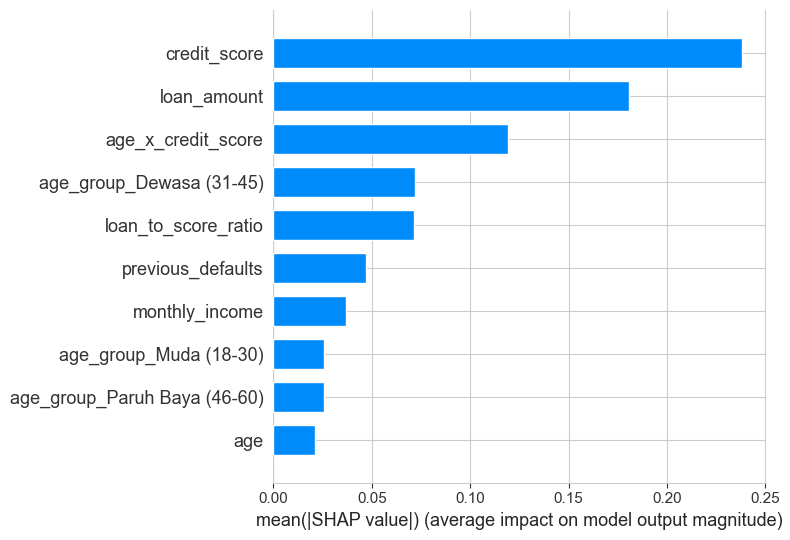

In [33]:
lr_shap = LogisticRegression(class_weight='balanced', random_state=42, solver='liblinear')
lr_shap.fit(X_train_scaled, y_train)

# SHAP analysis
model_fn = lambda x: lr_shap.predict_proba(x)[:, 1]
background = shap.sample(X_train_scaled, 100, random_state=42)

explainer = shap.KernelExplainer(model_fn, background)
shap_values = explainer.shap_values(X_test_scaled)

shap.summary_plot(shap_values, X_test_scaled, plot_type="bar", max_display=10, show=False)
plt.savefig("shap_top_10_features.png", bbox_inches="tight", dpi=150)
plt.show()

Grafik di atas menunjukkan 10 fitur teratas yang paling berpengaruh terhadap prediksi model. Panjang bar merepresentasikan kontribusi rata rata sebuah fitur dalam menentukan prediksi risiko. Terlihat bahwa fitur credit score memiliki pengaruh yang paling besar, ini masuk akal karena skor kredit pada dasarnya adalah rangkuman riwayat kredit seseorang dan kesehatan finansial seseorang. Yang kedua ada loan amount, ini juga masuk akal karena semakin besar pinjaman yang diberikan semakin besar pula risiko gagal bayar.